# TransferLearningTutorial
<br>이 예제는 파이토치 전이학습(https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html) 에 기반하여 실습한 내용입니다. 설명은 제 임의로 추가한 것일 수 있습니다. 개미 사진과 벌 사진을 구별하는 것을 목표로 합니다.

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

학습에 사용되는 데이터는 (https://download.pytorch.org/tutorial/hymenoptera_data.zip)에서 다운로드 할 수 있습니다.

In [11]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
  
data_dir = 'hymenoptera_data'
# 이미지 데이터셋의 형태로 트레이닝과 밸리데이션 데이터셋을 준비합니다.
# 이 ImageFolder클래스에 폴더를 집어 넣으면, raw이미지를 읽어서 데이터셋을 만들어 주는데, 
# 이 때, 폴더명이 classname(Supervised Learning에서 Label)이 됩니다.
# 두번째 인자인 data_transforms는 경로에서 읽어진 데이터를 tensor의 형태로 변환하는 작업을 명시해주는 것입니다.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

#DataLoader는 그렇게 생성된 리스트 형태의 이미지들을 배치단위로, 또 섞어서 묶은 데이터 형태가 됩니다. 
#num_workers는 몇개의 서브 프로세스를 이용해서 로드할 것인가를 명시한다고 합니다.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

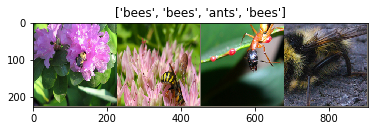

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 오버피팅을 방지하기 위해 validation을 꼭 해보고, 
            # validation시에 가장 높은 정확도의 에폭의 모델만 저장한다.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소, 트레이닝 때만 매 에폭마다 한번씩 불림.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\canca/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 18.9MB/s]


In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


C:\Users\canca\Anaconda3\envs\venv37\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7121 Acc: 0.6967
val Loss: 0.8935 Acc: 0.7190

Epoch 1/24
----------
train Loss: 0.7827 Acc: 0.7623
val Loss: 0.8209 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.8287 Acc: 0.7377
val Loss: 0.2809 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.7803 Acc: 0.7418
val Loss: 0.3914 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.7721 Acc: 0.7910
val Loss: 0.5781 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.7067 Acc: 0.7828
val Loss: 0.6528 Acc: 0.7778

Epoch 6/24
----------
train Loss: 0.6714 Acc: 0.7828
val Loss: 0.3987 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.3283 Acc: 0.8811
val Loss: 0.3258 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.2723 Acc: 0.8852
val Loss: 0.2949 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.4011 Acc: 0.8279
val Loss: 0.2832 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3625 Acc: 0.8443
val Loss: 0.2974 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3045 Acc: 0.8648
val Loss: 0.2612 Acc: 0.9150

Epoch 12/24
----------
t